In [1]:
# data process

import gzip
import glob
import datetime
import pandas as pd
import numpy as np
from collections import Counter
from geopy.distance import great_circle

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# read tower location
tower = pd.read_csv('Senegal/SITE_ARR_LONLAT.csv')
tower.head()

,site_id,arr_id,lon,lat
0,1,2,-17.525142,14.746832
1,2,2,-17.524360,14.747434
2,3,2,-17.522576,14.745198
3,4,2,-17.516398,14.746730
4,5,2,-17.512870,14.740658


In [3]:
# read tower region
region = pd.read_csv('Senegal/SENEGAL_ARR_V2.csv')
region.head()

,ARR_ID,REG,DEPT,ARR
0,1,DAKAR,DAKAR,PARCELLES ASSAINIES
1,2,DAKAR,DAKAR,ALMADIES
2,3,DAKAR,DAKAR,GRAND DAKAR
3,4,DAKAR,DAKAR,DAKAR PLATEAU
4,5,DAKAR,GUEDIAWAYE,GUEDIAWAYE


In [4]:
# merge tower id with region id
tower_region = tower.merge(region, left_on='arr_id', right_on='ARR_ID')
tower_region.head()

,site_id,arr_id,lon,lat,ARR_ID,REG,DEPT,ARR
0,1,2,-17.525142,14.746832,2,DAKAR,DAKAR,ALMADIES
1,2,2,-17.524360,14.747434,2,DAKAR,DAKAR,ALMADIES
2,3,2,-17.522576,14.745198,2,DAKAR,DAKAR,ALMADIES
3,4,2,-17.516398,14.746730,2,DAKAR,DAKAR,ALMADIES
4,5,2,-17.512870,14.740658,2,DAKAR,DAKAR,ALMADIES


In [5]:
# split tower into 1km * 1km grid (~0.01 degree * 0.01 degree)
tower_region['cellid'] = tower_region.apply(lambda row: str(round(row.lon, 2)) + '_' + str(round(row.lat, 2)), axis=1)
tower_region.head()

,site_id,arr_id,lon,lat,ARR_ID,REG,DEPT,ARR,cellid
0,1,2,-17.525142,14.746832,2,DAKAR,DAKAR,ALMADIES,-17.53_14.75
1,2,2,-17.524360,14.747434,2,DAKAR,DAKAR,ALMADIES,-17.52_14.75
2,3,2,-17.522576,14.745198,2,DAKAR,DAKAR,ALMADIES,-17.52_14.75
3,4,2,-17.516398,14.746730,2,DAKAR,DAKAR,ALMADIES,-17.52_14.75
4,5,2,-17.512870,14.740658,2,DAKAR,DAKAR,ALMADIES,-17.51_14.74


In [6]:
tower_to_cell = {}
for i in range(len(tower_region)):
    tower_to_cell[tower_region.iloc[i,0]] = [tower_region.iloc[i,8], tower_region.iloc[i,5]]
tower_to_cell

{1: ['-17.53_14.75', 'DAKAR'],
 2: ['-17.52_14.75', 'DAKAR'],
 3: ['-17.52_14.75', 'DAKAR'],
 4: ['-17.52_14.75', 'DAKAR'],
 5: ['-17.51_14.74', 'DAKAR'],
 6: ['-17.51_14.75', 'DAKAR'],
 7: ['-17.51_14.74', 'DAKAR'],
 8: ['-17.51_14.73', 'DAKAR'],
 9: ['-17.51_14.74', 'DAKAR'],
 10: ['-17.51_14.75', 'DAKAR'],
 11: ['-17.51_14.75', 'DAKAR'],
 12: ['-17.5_14.75', 'DAKAR'],
 13: ['-17.5_14.73', 'DAKAR'],
 14: ['-17.5_14.73', 'DAKAR'],
 15: ['-17.49_14.75', 'DAKAR'],
 16: ['-17.49_14.72', 'DAKAR'],
 17: ['-17.49_14.73', 'DAKAR'],
 18: ['-17.49_14.73', 'DAKAR'],
 19: ['-17.49_14.72', 'DAKAR'],
 20: ['-17.49_14.76', 'DAKAR'],
 21: ['-17.49_14.75', 'DAKAR'],
 22: ['-17.49_14.75', 'DAKAR'],
 23: ['-17.49_14.75', 'DAKAR'],
 24: ['-17.49_14.72', 'DAKAR'],
 25: ['-17.49_14.71', 'DAKAR'],
 26: ['-17.49_14.73', 'DAKAR'],
 27: ['-17.48_14.72', 'DAKAR'],
 28: ['-17.48_14.72', 'DAKAR'],
 29: ['-17.48_14.73', 'DAKAR'],
 30: ['-17.48_14.71', 'DAKAR'],
 31: ['-17.48_14.76', 'DAKAR'],
 32: ['-17.48_14.7',

In [7]:
# convert datetime
def string_to_datetime(x):
    rst = datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S')
    return rst, rst.strftime('%s')

print string_to_datetime('2013-01-07 13:10:00')

(datetime.datetime(2013, 1, 7, 13, 10), '1357535400')


In [8]:
# Save data
df = pd.read_csv('Senegal/set2/SET2_P01.CSV.gz', header=None, compression='gzip', sep=',')
#df = pd.read_csv('Senegal/set2/SET2_P16.CSV.gz', header=None, compression='gzip', sep=',')

In [9]:
df.columns = ['userid', 'time', 'towerid']
df.head()

,userid,time,towerid
0,1,2013-01-07 13:10:00,461
1,1,2013-01-07 17:20:00,454
2,1,2013-01-07 17:30:00,454
3,1,2013-01-07 18:40:00,327
4,1,2013-01-07 20:30:00,323


In [10]:
# convert to DateTime
df['datetime'] = pd.to_datetime(df['time'], format = '%Y-%m-%d %H:%M:%S')
df.head()

,userid,time,towerid,datetime
0,1,2013-01-07 13:10:00,461,2013-01-07 13:10:00
1,1,2013-01-07 17:20:00,454,2013-01-07 17:20:00
2,1,2013-01-07 17:30:00,454,2013-01-07 17:30:00
3,1,2013-01-07 18:40:00,327,2013-01-07 18:40:00
4,1,2013-01-07 20:30:00,323,2013-01-07 20:30:00


In [11]:
# convert to Timestamp in seconds
df['timestamp'] = df['datetime'].astype(np.int64)//10**9
df.head()

,userid,time,towerid,datetime,timestamp
0,1,2013-01-07 13:10:00,461,2013-01-07 13:10:00,1357564200
1,1,2013-01-07 17:20:00,454,2013-01-07 17:20:00,1357579200
2,1,2013-01-07 17:30:00,454,2013-01-07 17:30:00,1357579800
3,1,2013-01-07 18:40:00,327,2013-01-07 18:40:00,1357584000
4,1,2013-01-07 20:30:00,323,2013-01-07 20:30:00,1357590600


In [12]:
# merge user level data with cell tower information
user_cellid = df.merge(tower_region, left_on='towerid', right_on='site_id')
user_cellid.head()

,userid,time,towerid,datetime,timestamp,site_id,arr_id,lon,lat,ARR_ID,REG,DEPT,ARR,cellid
0,1,2013-01-07 13:10:00,461,2013-01-07 13:10:00,1357564200,461,9,-17.262507,14.714573,9,DAKAR,RUFISQUE,RUFISQUE,-17.26_14.71
1,74,2013-01-18 10:10:00,461,2013-01-18 10:10:00,1358503800,461,9,-17.262507,14.714573,9,DAKAR,RUFISQUE,RUFISQUE,-17.26_14.71
2,89,2013-01-10 10:00:00,461,2013-01-10 10:00:00,1357812000,461,9,-17.262507,14.714573,9,DAKAR,RUFISQUE,RUFISQUE,-17.26_14.71
3,154,2013-01-07 21:50:00,461,2013-01-07 21:50:00,1357595400,461,9,-17.262507,14.714573,9,DAKAR,RUFISQUE,RUFISQUE,-17.26_14.71
4,154,2013-01-07 23:10:00,461,2013-01-07 23:10:00,1357600200,461,9,-17.262507,14.714573,9,DAKAR,RUFISQUE,RUFISQUE,-17.26_14.71


In [13]:
# print the sorted traj of one user
user_cellid.loc[lambda df:df.userid == 1, :].sort_values(by=['timestamp'])

,userid,time,towerid,datetime,timestamp,site_id,arr_id,lon,lat,ARR_ID,REG,DEPT,ARR,cellid
0,1,2013-01-07 13:10:00,461,2013-01-07 13:10:00,1357564200,461,9,-17.262507,14.714573,9,DAKAR,RUFISQUE,RUFISQUE,-17.26_14.71
53058,1,2013-01-07 17:20:00,454,2013-01-07 17:20:00,1357579200,454,9,-17.270324,14.715575,9,DAKAR,RUFISQUE,RUFISQUE,-17.27_14.72
53059,1,2013-01-07 17:30:00,454,2013-01-07 17:30:00,1357579800,454,9,-17.270324,14.715575,9,DAKAR,RUFISQUE,RUFISQUE,-17.27_14.72
188000,1,2013-01-07 18:40:00,327,2013-01-07 18:40:00,1357584000,327,6,-17.396561,14.759777,6,DAKAR,PIKINE,PIKINE DAGOUDANE,-17.4_14.76
277777,1,2013-01-07 20:30:00,323,2013-01-07 20:30:00,1357590600,323,5,-17.396113,14.774319,5,DAKAR,GUEDIAWAYE,GUEDIAWAYE,-17.4_14.77
277778,1,2013-01-08 18:40:00,323,2013-01-08 18:40:00,1357670400,323,5,-17.396113,14.774319,5,DAKAR,GUEDIAWAYE,GUEDIAWAYE,-17.4_14.77
277779,1,2013-01-08 19:30:00,323,2013-01-08 19:30:00,1357673400,323,5,-17.396113,14.774319,5,DAKAR,GUEDIAWAYE,GUEDIAWAYE,-17.4_14.77
277780,1,2013-01-08 21:00:00,323,2013-01-08 21:00:00,1357678800,323,5,-17.396113,14.774319,5,DAKAR,GUEDIAWAYE,GUEDIAWAYE,-17.4_14.77
277781,1,2013-01-09 11:00:00,323,2013-01-09 11:00:00,1357729200,323,5,-17.396113,14.774319,5,DAKAR,GUEDIAWAYE,GUEDIAWAYE,-17.4_14.77
277782,1,2013-01-09 14:50:00,323,2013-01-09 14:50:00,1357743000,323,5,-17.396113,14.774319,5,DAKAR,GUEDIAWAYE,GUEDIAWAYE,-17.4_14.77


In [14]:
city = 'DAKAR'
user_cellid_region = user_cellid.loc[user_cellid['REG'] == city]
print(len(user_cellid_region))
user_cellid_region.head()

25677017


,userid,time,towerid,datetime,timestamp,site_id,arr_id,lon,lat,ARR_ID,REG,DEPT,ARR,cellid
0,1,2013-01-07 13:10:00,461,2013-01-07 13:10:00,1357564200,461,9,-17.262507,14.714573,9,DAKAR,RUFISQUE,RUFISQUE,-17.26_14.71
1,74,2013-01-18 10:10:00,461,2013-01-18 10:10:00,1358503800,461,9,-17.262507,14.714573,9,DAKAR,RUFISQUE,RUFISQUE,-17.26_14.71
2,89,2013-01-10 10:00:00,461,2013-01-10 10:00:00,1357812000,461,9,-17.262507,14.714573,9,DAKAR,RUFISQUE,RUFISQUE,-17.26_14.71
3,154,2013-01-07 21:50:00,461,2013-01-07 21:50:00,1357595400,461,9,-17.262507,14.714573,9,DAKAR,RUFISQUE,RUFISQUE,-17.26_14.71
4,154,2013-01-07 23:10:00,461,2013-01-07 23:10:00,1357600200,461,9,-17.262507,14.714573,9,DAKAR,RUFISQUE,RUFISQUE,-17.26_14.71


In [18]:
# export data for Kevin
#sample = user_cellid_region[user_cellid_region['userid'] <= 1000]
#sample.to_csv('sample.csv', index=False)

In [15]:
# estimate levy flight
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.deg2rad, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371.0 # Radius of earth in kilometers. Use 3956 for miles
    return c * r


In [156]:
# not group by timebin
jump = {}
for user, traj in user_cellid_region.groupby('userid'):
    if len(jump) % 10000 == 0:
        print len(jump)
    
    tmp = traj.sort_values(by=['timestamp'])
    lon, lat = tmp['lon'].values, tmp['lat'].values
    distance = haversine(lon[1:], lat[1:], lon[:-1], lat[:-1])
    jump[user] = distance[distance != 0]

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000


In [32]:
### speed up version ###
# detect nighttime tower, and stay tower
user_stay = {}

for user, traj in user_cellid_region.groupby('userid'):
    if len(user_stay) % 10000 == 0:
        print len(user_stay)
        
    user_stay[user] = {}
    tmp = traj.sort_values(by=['timestamp'])
    tmp['hour'] = tmp.datetime.apply(lambda x: x.hour)

    night = tmp.loc[(tmp['hour'] <= 7) | (tmp['hour'] >= 19)]['cellid'].values
    dayti = tmp.loc[(tmp['hour'] >= 10) & (tmp['hour'] <= 17)]['cellid'].values
    deltatime = tmp['timestamp'].values[1:] - tmp['timestamp'].values[:-1] # diff timestamp
    deltatower = 1*(tmp['cellid'].values[1:] != tmp['cellid'].values[:-1]) # 1 move, 0 stay
    cellid = tmp['cellid'].values[1:]
    flags = [[deltatime[i], deltatower[i], cellid[i]] for i in range(len(deltatime))]
    
    user_stay[user]['night'] = night
    user_stay[user]['dayti'] = dayti
    user_stay[user]['tower'] = flags
    user_stay[user]['stay'] = []
    
    # detect stay point
    run = []
    result = []
    for k in flags:
        if k[1] == 0: #if stay
            run.append(k)
        else:
            result.append(run)
            run = []
    for m in result:
        if len(m) > 0:
            staytime = sum([i[0] for i in m])
            staytower = m[0][2]
            if staytime >= 2*60*60: # two hour 
                user_stay[user]['stay'].append([staytime, staytower])

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000


In [116]:
### old version ###
# detect nighttime tower, and stay tower
user_stay = {}

for user, traj in user_cellid_region.groupby('userid'):
    if len(user_stay) % 10000 == 0:
        print len(user_stay)
        
    user_stay[user] = {}
    tmp = traj.sort_values(by=['timestamp'])
    night = []
    dayti = []
    flags = []
    N = len(tmp)
    for i in range(N):
        H = tmp.iloc[i,]['datetime'].hour # hour of the time
        if H <= 7 or H >= 19: # 7pm to 7am
            night.append(tmp.iloc[i,]['cellid']) # add nighttime cell id
        if H >= 10 and H <= 17: #10am to 5pm
            dayti.append(tmp.iloc[i,]['cellid'])
        if i != 0:
            deltatime = tmp.iloc[i,]['timestamp'] - tmp.iloc[i-1,]['timestamp']
            if tmp.iloc[i,]['cellid'] == tmp.iloc[i-1,]['cellid']:
                deltatower = 0 # stay at the same tower
            else:
                deltatower = 1 # move
            flags.append([deltatime, deltatower, tmp.iloc[i,]['cellid']]) #time interval, if_same_tower, towerid
    
    user_stay[user]['night'] = night
    user_stay[user]['dayti'] = dayti
    user_stay[user]['tower'] = flags
    user_stay[user]['stay'] = []
    
    # detect stay point
    run = []
    result = []
    for k in flags:
        if k[1] == 0: #stay at the same tower
            run.append(k)
        else:
            result.append(run)
            run = []
    for m in result:
        if len(m) > 0:
            staytime = sum([i[0] for i in m])
            staytower = m[0][2]
            if staytime >= 2*60*60: # two hour 
                user_stay[user]['stay'].append([staytime, staytower])
            
        

0


KeyboardInterrupt: 

In [33]:
len(user_stay)

173398

In [34]:
# export home and visit
user_home = []
user_work = []
user_visit = []
for user in user_stay:
    try:
        loca, cnt = Counter(user_stay[user]['night']).most_common(1)[0]
        user_home.append([user, loca, cnt])
        loca, cnt = Counter(user_stay[user]['dayti']).most_common(1)[0]
        user_work.append([user, loca, cnt])
        stays = user_stay[user]['stay']
        for s in stays:
            user_visit.append([user, s[1], s[0]])
    except:
        continue

In [191]:
dt = pd.DataFrame(user_home, columns = ['userid', 'location', 'cnt'])
dt.to_csv(city + '_HOME_SET2_P01.CSV', index=False, sep=',')

dt = pd.DataFrame(user_work, columns = ['userid', 'location', 'cnt'])
dt.to_csv(city + '_WORK_SET2_P01.CSV', index=False, sep=',')

dt = pd.DataFrame(user_visit, columns = ['userid', 'location', 'staytime'])
dt.to_csv(city + '_VISIT_SET2_P01.CSV', index=False, sep=',')

In [35]:
### Analysis

import matplotlib.pyplot as plt
import statsmodels.api as sm


ImportError: No module named statsmodels.api

In [36]:
user_home = pd.read_csv('Senegal/DAKAR_HOME_SET2_P16.csv')
user_home.head()

,userid,location,cnt
0,1,-17.46_14.73,18
1,3,-17.41_14.77,19
2,4,-17.28_14.76,10
3,5,-17.34_14.77,7
4,7,-17.27_14.71,8


In [37]:
user_work = pd.read_csv('Senegal/DAKAR_WORK_SET2_P16.csv')
user_work.head()

,userid,location,cnt
0,1,-17.46_14.73,18
1,3,-17.41_14.77,44
2,4,-17.29_14.77,1
3,5,-17.34_14.77,18
4,7,-17.27_14.71,23


In [38]:
user_visit = pd.read_csv('Senegal/DAKAR_VISIT_SET2_P16.csv')
user_visit.head()

,userid,location,staytime
0,1,-17.46_14.74,9000
1,1,-17.46_14.73,316800
2,1,-17.46_14.73,86400
3,1,-17.46_14.73,193200
4,1,-17.46_14.73,88800


In [39]:
# export data for R
df_merge = user_home.merge(user_visit, left_on='userid', right_on='userid')
df_merge.columns = ['userid', 'home', 'homecnt', 'cell', 'staytime']
df_merge.head()

,userid,home,homecnt,cell,staytime
0,1,-17.46_14.73,18,-17.46_14.74,9000
1,1,-17.46_14.73,18,-17.46_14.73,316800
2,1,-17.46_14.73,18,-17.46_14.73,86400
3,1,-17.46_14.73,18,-17.46_14.73,193200
4,1,-17.46_14.73,18,-17.46_14.73,88800


In [40]:
rst = []
for k, v in df_merge.groupby(['userid', 'home', 'cell']):
    userid = k[0]
    home = k[1]
    cell = k[2]
    hlon, hlat = map(float, home.split('_'))
    clon, clat = map(float, cell.split('_'))
    dist = great_circle((clat, clon), (hlat, hlon)).km
    f = len(v)
    rst.append([userid, home, cell, f, dist, f*dist, hlon, hlat, clon, clat])


In [60]:
df_rst = pd.DataFrame(rst, columns = ['userid', 'home', 'cell', 'f', 'r', 'rf', 'homelon', 'homelat', 'celllon', 'celllat'])
#df_rst.to_csv('Dakar_P16.csv', index=False, sep=',')
### End of the export code ###

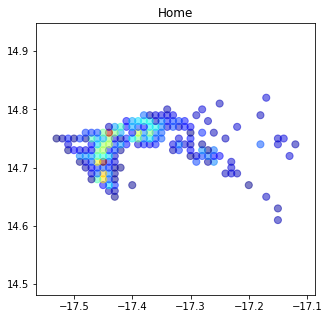

In [22]:
# home location
LON = []
LAT = []
CNT = []
for loca, v in user_home.groupby('location'):
    lon, lat = map(float, loca.split('_'))
    LON.append(lon)
    LAT.append(lat)
    CNT.append(len(v))

plt.figure(figsize=(5,5))
plt.scatter(LON, LAT, s=50, c=np.array(CNT)*255./np.max(CNT), cmap='jet', alpha=0.5)
plt.title('Home')
plt.axis('equal')
plt.show()

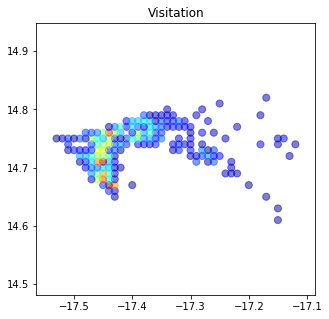

In [23]:
# visit location
LON = []
LAT = []
CNT = []
for loca, v in user_visit.groupby('location'):
    lon, lat = map(float, loca.split('_'))
    LON.append(lon)
    LAT.append(lat)
    CNT.append(len(v))
    
plt.figure(figsize=(5,5))
plt.scatter(LON, LAT, s=50, c=np.array(CNT)*255./np.max(CNT), cmap='jet', alpha=0.5)
plt.title('Visitation')
plt.axis('equal')
plt.show()

In [24]:
###
dist_dict = {}
home = {} # {userid: location}
work = {} # {userid: location}
visit = {} # {location: {user1: [freq1, dist], user2: [freq2, dist]}}
for i in range(len(user_home)):
    userid = user_home.iloc[i, 0]
    home[userid] = user_home.iloc[i, 1]

for i in range(len(user_work)):
    userid = user_work.iloc[i, 0]
    work[userid] = user_work.iloc[i, 1]
    
for i in range(len(user_visit)):
    userid = user_visit.iloc[i, 0]
    try:
        hloca = home[userid] # must have home location
        wloca = work[userid]
    except:
        continue
        
    vloca = user_visit.iloc[i, 1] # location of visitation
    
    # not work location
    #if vloca == wloca:
    #    continue
        
    key = (vloca, hloca)
    if key not in dist_dict:
        vlon, vlat = map(float, vloca.split('_'))
        hlon, hlat = map(float, hloca.split('_'))
        dist = great_circle((vlat, vlon), (hlat, hlon)).km
        dist_dict[key] = dist
    
    if vloca not in visit:
        visit[vloca] = {userid: [1, dist_dict[key]]}
    else:
        if userid not in visit[vloca]:
            visit[vloca][userid] = [1, dist_dict[key]]
        else:
            visit[vloca][userid][0] += 1


In [25]:
len(visit)

173

In [26]:
visit[vloca]

{83: [1, 1.0753075413385564],
 2342: [4, 4.442540405205069],
 9676: [14, 0.0],
 10380: [3, 5.490197051516513],
 13134: [2, 0.0],
 14984: [3, 0.0],
 17151: [1, 1.0753075413385564],
 17495: [1, 1.0753075413385564],
 18855: [8, 0.0],
 19194: [5, 0.0],
 20537: [4, 0.0],
 20826: [3, 0.0],
 20963: [1, 3.504904788895484],
 21423: [3, 0.0],
 21432: [1, 5.818095777270421],
 21520: [2, 7.410876467352796],
 22454: [2, 0.0],
 22876: [8, 0.0],
 23456: [8, 0.0],
 24374: [2, 0.0],
 24550: [1, 2.421113871263267],
 27656: [2, 0.0],
 27722: [1, 1.0753075413385564],
 29719: [5, 0.0],
 32241: [1, 1.0753075413385564],
 32320: [3, 1.0753075413385564],
 32377: [2, 0.0],
 37556: [5, 0.0],
 38744: [4, 0.0],
 39060: [5, 1.0753075413385564],
 41882: [12, 0.0],
 44433: [1, 3.5049047888955887],
 44554: [2, 1.0753075413385564],
 47258: [2, 4.442731758800498],
 48473: [11, 1.0753075413385564],
 48534: [2, 0.0],
 48598: [12, 0.0],
 49954: [2, 0.0],
 50513: [2, 0.0],
 50678: [3, 1.0753075413385564],
 51570: [1, 0.0],


In [29]:
rf = {}
for loca in visit:
    for user in visit[loca]:
        freq = visit[loca][user][0]
        radi = int(visit[loca][user][1])
        if radi > 0 and radi <= 20: # the radius of Dakar is 20km
            if freq not in rf:
                rf[freq] = {radi: 1}
            else:
                if radi not in rf[freq]:
                    rf[freq][radi] = 1
                else:
                    rf[freq][radi] += 1
                


In [39]:
# logbins for tail (>10km)
print(np.logspace(0, 7, num = 20, base=2))
bins = {1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9, 10:10, 
        11:11.5, 12:11.5, 13:13.5, 14:13.5, 15:16, 16:16, 17:16, 18:19.5, 19:19.5, 20:19.5, 21:19.5}

[  1.           1.2909392    1.66652401   2.15138117   2.77730229
   3.58532838   4.62844095   5.97503585   7.71340798   9.95754072
  12.85457963  16.59448071  21.42246562  27.65510059  35.70105337
  46.0878892   59.49666272  76.80657405  99.15261711 128.        ]


In [31]:
f1 = {}
f1_ = {}
f2 = {}
f2_ = {}
f4 = {}
f4_ = {}
f8 = {}
f8_ = {}
for k in rf[1]:
    x = bins[k]
    if x not in f1:
        f1[x] = rf[1][k]
    else:
        f1[x] += rf[1][k]
    
    if x not in f1_:
        f1_[x*1*1] = rf[1][k]
    else:
        f1_[x*1*1] += rf[1][k]
        
for k in rf[2]:
    x = bins[k]
    if x not in f2:
        f2[x] = rf[2][k]
    else:
        f2[x] += rf[2][k]
        
    if x*2*2 not in f2_:
        f2_[x*2*2] = rf[2][k]
    else:
        f2_[x*2*2] += rf[2][k]

for k in rf[4]:
    x = bins[k]
    if x not in f4:
        f4[x] = rf[4][k]
    else:
        f4[x] += rf[4][k]
    
    if x*4*4 not in f4_:
        f4_[x*4*4] = rf[4][k]
    else:
        f4_[x*4*4] += rf[4][k]

for k in rf[8]:
    x = bins[k]
    if x not in f8:
        f8[x] = rf[8][k]
    else:
        f8[x] += rf[8][k]
    
    if x*8*8 not in f8_:
        f8_[x*8*8] = rf[8][k]
    else:
        f8_[x*8*8] += rf[8][k]

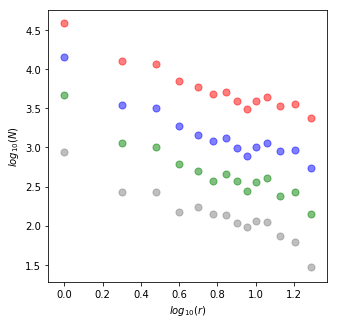

In [32]:
plt.figure(figsize=(5,5))
plt.scatter(np.log10([i for i in f1]), np.log10([f1[i] for i in f1]), s=50, c='red', alpha=0.5)
plt.scatter(np.log10([i for i in f2]), np.log10([f2[i] for i in f2]), s=50, c='blue', alpha=0.5)
plt.scatter(np.log10([i for i in f4]), np.log10([f4[i] for i in f4]), s=50, c='green', alpha=0.5)
plt.scatter(np.log10([i for i in f8]), np.log10([f8[i] for i in f8]), s=50, c='gray', alpha=0.5)
plt.xlabel(r'$log_{10}(r)$')
plt.ylabel(r'$log_{10}(N)$')
plt.show()

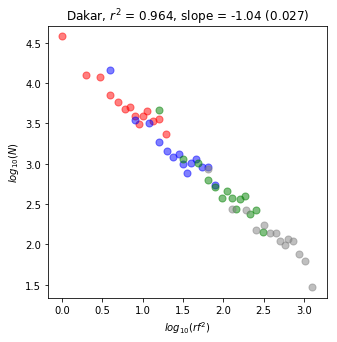

In [33]:
plt.figure(figsize=(5,5))
plt.scatter(np.log10([i for i in f1_]), np.log10([f1_[i] for i in f1_]), s=50, c='red', alpha=0.5)
plt.scatter(np.log10([i for i in f2_]), np.log10([f2_[i] for i in f2_]), s=50, c='blue', alpha=0.5)
plt.scatter(np.log10([i for i in f4_]), np.log10([f4_[i] for i in f4_]), s=50, c='green', alpha=0.5)
plt.scatter(np.log10([i for i in f8_]), np.log10([f8_[i] for i in f8_]), s=50, c='gray', alpha=0.5)
plt.xlabel(r'$log_{10}(rf^2)$')
plt.ylabel(r'$log_{10}(N)$')
plt.title(r'Dakar, $r^2$ = 0.964, slope = -1.04 (0.027)')
plt.axis('equal')
plt.show()

In [34]:
X = []
Y = []
for i in f1_:
    X.append(i)
    Y.append(f1_[i])
for i in f2_:
    X.append(i)
    Y.append(f2_[i])
for i in f4_:
    X.append(i)
    Y.append(f4_[i])
for i in f8_:
    X.append(i)
    Y.append(f8_[i])
    
fitted = sm.OLS(np.log10(X), sm.add_constant(np.log10(Y))).fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     2282.
Date:                Thu, 14 Mar 2019   Prob (F-statistic):           7.28e-46
Time:                        16:33:01   Log-Likelihood:                 41.545
No. Observations:                  56   AIC:                            -79.09
Df Residuals:                      54   BIC:                            -75.04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9082      0.069     71.308      0.0

In [17]:
odmatrix = {}
for loca in visit:
    for user in visit[loca]:
        hloca = home[user]
        if (hloca, loca) not in odmatrix:
            odmatrix[(hloca, loca)] = [user]
        else:
            if user not in odmatrix[(hloca, loca)]:
                odmatrix[(hloca, loca)].append(user)
            
            
r_avg_f = {}
for loca in visit:
    for user in visit[loca]:
        freq = visit[loca][user][0]
        radi = visit[loca][user][1]
        # <r> = K/f
        #if freq <= 15:
        if freq <= 14 and loca != work[user]:
            if freq not in r_avg_f:
                r_avg_f[freq] = [radi]
            else:
                r_avg_f[freq].append(radi)
                

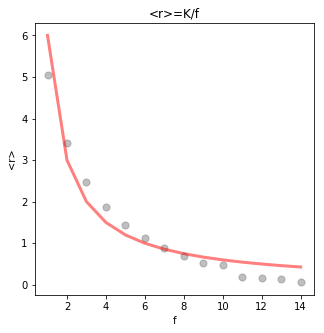

In [18]:
f_pred = [i+1 for i in range(14)]
r_pred = [6./i for i in f_pred]

# plot
plt.figure(figsize=(5,5))
plt.scatter([i for i in r_avg_f], [np.mean(r_avg_f[i]) for i in r_avg_f], s=50, c='gray', alpha=0.5)
plt.plot(f_pred, r_pred, c='red', lw=3, alpha=0.5)
plt.title(r'<r>=K/f')
plt.xlabel(r'f')
plt.ylabel(r'<r>')
plt.show()

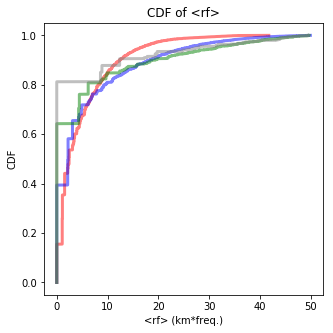

In [18]:
### CDF rescale
cdf = []
for loca in visit:
    for user in visit[loca]:
        freq = visit[loca][user][0]
        radi = visit[loca][user][1]
        if radi*freq <= 50:
            cdf.append([radi, freq, radi*freq])
len(cdf)


cdf1x = np.sort([i[2] for i in cdf if i[1] == 1])
cdf1y = np.arange(len(cdf1x))/float(len(cdf1x)-1)
cdf2x = np.sort([i[2] for i in cdf if i[1] == 2])
cdf2y = np.arange(len(cdf2x))/float(len(cdf2x)-1)
cdf4x = np.sort([i[2] for i in cdf if i[1] == 4])
cdf4y = np.arange(len(cdf4x))/float(len(cdf4x)-1)
cdf8x = np.sort([i[2] for i in cdf if i[1] == 8])
cdf8y = np.arange(len(cdf8x))/float(len(cdf8x)-1)

# plot
plt.figure(figsize=(5,5))
plt.plot(cdf1x, cdf1y, lw=3, c='red', alpha=0.5) 
plt.plot(cdf2x, cdf2y, lw=3, c='blue', alpha=0.5) 
plt.plot(cdf4x, cdf4y, lw=3, c='green', alpha=0.5) 
plt.plot(cdf8x, cdf8y, lw=3, c='gray', alpha=0.5)
plt.title('CDF of <rf>')
plt.xlabel(r'<rf> (km*freq.)')
plt.ylabel('CDF')
plt.show()

In [25]:
loca_energy = {}
for loca in visit:
    #uniq_user = len(visit[loca])
    # uniq user non home location at loca
    loca_energy[loca] = [0, 0, 0] # distance*freq, user, freq
    for user in visit[loca]:
        freq = visit[loca][user][0]
        radi = visit[loca][user][1]
        #if freq <=14 and radi <= 20 and radi > 0 and loca != work[user] and loca != home[user]:
        if freq <=14 and radi <= 20 and loca != home[user]:
            loca_energy[loca][0] += freq * radi
            loca_energy[loca][1] += 1
            loca_energy[loca][2] += freq

In [26]:
LON = []
LAT = []
VISITOR = []
ENERGY_USER = []
ENERGY_TRIP = []
for loca in loca_energy:
    lon, lat = map(float, loca.split('_'))
    LON.append(lon)
    LAT.append(lat)
    VISITOR.append(loca_energy[loca][1])
    ENERGY_USER.append(loca_energy[loca][0]/loca_energy[loca][1])
    ENERGY_TRIP.append(loca_energy[loca][0]/loca_energy[loca][2])

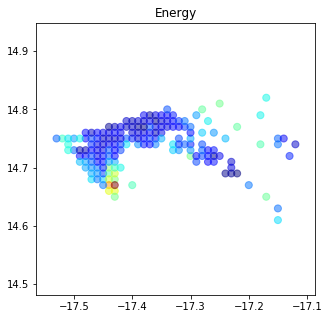

In [27]:
plt.figure(figsize=(5,5))
plt.scatter(LON, LAT, s=50, c=np.array(ENERGY_USER)*255./np.max(ENERGY_USER), cmap='jet', alpha=0.5)
plt.title('Energy')
plt.axis('equal')
plt.show()